In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import h5py

import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import InputLayer, Dense, Input, Dropout, Flatten, Conv2D,MaxPool2D
from keras.losses import CategoricalCrossentropy
from keras.optimizers import Adam
from keras.regularizers import l1, l2

from tensorflow.keras import utils
from tensorflow.keras import backend as K

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import pydot
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot

import pickle
import json

C:\Users\ANCI\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
tf.__version__

'2.9.1'

In [3]:
hdf5_x_file = 'dataset/camelyonpatch_x.h5'
hdf5_y_file = 'dataset/camelyonpatch_y.h5'

hfx = h5py.File(hdf5_x_file, 'r')
hfy = h5py.File(hdf5_y_file, 'r')

X = hfx['x']
y = hfy['y']

print("X shape = ",X.shape)
print("y shape = ",y.shape)

X shape =  (32768, 96, 96, 3)
y shape =  (32768, 1, 1, 1)


### Konvertovanje u np.array

In [4]:
X = np.array(X)
y = np.array(y)

### Reshape iz  4D u 2D

In [5]:
nsamples, nx, ny, nrgb = X.shape
X_reshape = X.reshape((nsamples,nx*ny*nrgb))
print('2D X shape = ',X_reshape.shape)

y_reshape = y.ravel()
print('2D y shape = ',y_reshape.shape)

2D X shape =  (32768, 27648)
2D y shape =  (32768,)


In [6]:
print(X_reshape)

[[247 246 244 ... 243 241 244]
 [216 166 203 ... 227 213 226]
 [184 155 186 ... 251 205 242]
 ...
 [223 159 183 ... 192 113 160]
 [154  75 192 ...  67  10 107]
 [ 64   2  39 ... 197 137 165]]


In [7]:
print(y_reshape)

[0 1 0 ... 1 1 0]


### Podela na Train, Test i Validate podatke

In [8]:
X_train_and_val, X_test, y_train_and_val, y_test = train_test_split(X_reshape, y_reshape, test_size = 0.2, random_state = 42, stratify = y_reshape )
X_train, X_validation, y_train, y_validation = train_test_split(X_train_and_val, y_train_and_val, test_size = 0.25, random_state = 42, stratify = y_train_and_val)

In [9]:
X_train.shape

(19660, 27648)

In [10]:
X_test.shape

(6554, 27648)

In [11]:
X_validation.shape

(6554, 27648)

In [12]:
print(X_train)

[[254 233 238 ... 151 120 128]
 [178 130 190 ... 174  70 169]
 [ 60  23 126 ... 167 103 199]
 ...
 [215 210 217 ... 242 179 250]
 [246 161 220 ... 121  49 161]
 [ 77  34  64 ... 128  85 105]]


In [13]:
print(y_train)

[0 1 1 ... 1 1 0]


In [14]:
print(X_test)

[[121  86 128 ... 252 252 252]
 [242 242 242 ... 193  68 208]
 [174 141 158 ... 115  63  65]
 ...
 [220 113 207 ... 227 217 242]
 [171  66 185 ... 238 223 255]
 [221 225 224 ... 187 126 186]]


In [15]:
print(y_test)

[1 1 0 ... 0 1 0]


In [16]:
print(X_validation)

[[241 229 241 ... 229 224 231]
 [227 161 223 ...  58  34 144]
 [173  85 127 ... 134  63  97]
 ...
 [121  89 165 ... 159  97 183]
 [ 76  46 146 ... 214 167 222]
 [184  68 169 ... 253 219 254]]


In [17]:
print(y_validation)

[0 0 1 ... 0 1 1]


### Brisanje suvišnih podataka iz memorije i zatvaranje fajlova

In [18]:
del X, y, X_reshape, y_reshape

In [19]:
hfx.close()
hfy.close()

### Pravljenje kopija
Zbog rada na konvolutivnoj neuralnoj mrezi, pravim kopiju za X_test, X_train i X_validate.
Trebaju mi nestandardizovane kopije, jer za konvolutivnu normalizujem podatke

In [20]:
X_train_copy = X_train
X_validation_copy = X_validation
X_test_copy = X_test

### Provera stratifikovanosti

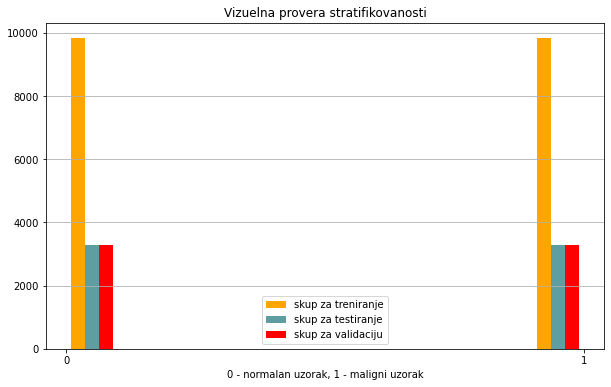

In [21]:
plt.figure(figsize = (10,6))
plt.title('Vizuelna provera stratifikovanosti')
plt.xticks([0,1])
plt.xlabel('0 - normalan uzorak, 1 - maligni uzorak')
plt.hist([y_train, y_test, y_validation], color=['orange', 'cadetblue', 'red'], label=['skup za treniranje', 'skup za testiranje','skup za validaciju'])
plt.legend(loc='best')
plt.grid(axis = 'y')
plt.show()

In [22]:
maligni_train = np.sum(y_train==1)
print('Broj instanci trening skupa koji sadrže maligna tkiva: ', maligni_train)
normalni_train = np.sum(y_train==0)
print('Broj normalnih instanci trening skupa: ', normalni_train)
odstupanje = np.abs(normalni_train - maligni_train)
procenat_odstupanja = odstupanje*100/X_train.shape[0]
print('Odstupanje: {0:d} ({1:.2f}%)\n=========================\n'.format(odstupanje, procenat_odstupanja))

maligni_test = np.sum(y_test==1)
print('Broj instanci test skupa koji sadrže maligna tkiva: ', maligni_test)
normalni_test = np.sum(y_test==0)
print('Broj normalnih instanci test skupa: ', normalni_test)
odstupanje = np.abs(normalni_test - maligni_test)
procenat_odstupanja = odstupanje*100/X_test.shape[0]
print('Odstupanje: {0:d} ({1:.2f}%)\n=========================\n'.format(odstupanje, procenat_odstupanja))

maligni_val = np.sum(y_validation==1)
print('Broj instanci validactiong skupa koji sadrže maligna tkiva: ', maligni_val)
normalni_val = np.sum(y_validation==0)
print('Broj normalnih instanci validacionog skupa: ', normalni_val)
odstupanje = np.abs(normalni_val - maligni_val)
procenat_odstupanja = odstupanje*100/X_validation.shape[0]
print('Odstupanje: {0:d} ({1:.2f}%)\n=========================\n'.format(odstupanje, procenat_odstupanja))

Broj instanci trening skupa koji sadrže maligna tkiva:  9826
Broj normalnih instanci trening skupa:  9834
Odstupanje: 8 (0.04%)

Broj instanci test skupa koji sadrže maligna tkiva:  3276
Broj normalnih instanci test skupa:  3278
Odstupanje: 2 (0.03%)

Broj instanci validactiong skupa koji sadrže maligna tkiva:  3275
Broj normalnih instanci validacionog skupa:  3279
Odstupanje: 4 (0.06%)



### Standardizacija

In [23]:
scaler_t = StandardScaler()
scaler_t.fit(X_train)
X_train = scaler_t.transform(X_train)
X_validation = scaler_t.transform(X_validation)

In [24]:
scaler_tv = StandardScaler()
scaler_tv.fit(X_train_and_val)
X_train_and_val = scaler_tv.transform(X_train_and_val)
X_test = scaler_tv.transform(X_test)

In [25]:
with open('assets/standard_scaler/ANN_Train_scaler.scaler.pickle', 'wb') as scaler_file:
    pickle.dump(scaler_t, scaler_file)

In [26]:
with open('assets/standard_scaler//ANN_Train_and_Validation_scaler.scaler.pickle', 'wb') as scaler_file:
    pickle.dump(scaler_tv, scaler_file)

In [27]:
#Ovde nam neće trebati ovaj skup podataka
del X_train_and_val

In [28]:
print(X_train)

[[ 1.30910312  1.38902285  1.17899234 ... -0.39282128 -0.21108891
  -0.94294384]
 [ 0.08647567 -0.03866716  0.26224548 ... -0.02588697 -0.89542089
  -0.17817272]
 [-1.81181431 -1.52180144 -0.96008367 ... -0.13756263 -0.44376179
   0.38141591]
 ...
 [ 0.68170219  1.07021828  0.77791559 ...  1.05896227  0.59642281
   1.33271658]
 [ 1.1804055   0.39102595  0.83521227 ... -0.87143124 -1.18284032
  -0.32739635]
 [-1.53833186 -1.36932969 -2.14421502 ... -0.75975558 -0.6901213
  -1.37196179]]


In [29]:
print(X_test)

[[-0.82465962 -0.64608368 -0.9201372  ...  1.22047286  1.59752775
   1.3723488 ]
 [ 1.11346154  1.50732707  1.25023735 ...  0.28118425 -0.92216486
   0.55153983]
 [ 0.02426949  0.11313165 -0.348986   ... -0.96058714 -0.99063477
  -2.11608934]
 ...
 [ 0.76107588 -0.27337797  0.58389429 ...  0.82246921  1.11823839
   1.18580131]
 [-0.02378311 -0.92216198  0.16505007 ...  0.99759082  1.20040228
   1.42831305]
 [ 0.77709341  1.27266051  0.90754663 ...  0.18566337 -0.12791393
   0.14113534]]


In [30]:
print(X_validation)

[[ 1.09996948  1.33357857  1.23628902 ...  0.85156462  1.21232159
   0.97831045]
 [ 0.87474863  0.39102595  0.89250895 ... -1.87651215 -1.38813991
  -0.64449657]
 [ 0.00603966 -0.66241522 -0.94098477 ... -0.66403359 -0.99122736
  -1.52118542]
 ...
 [-0.83049491 -0.60697095 -0.21522684 ... -0.26519195 -0.52588162
   0.08296864]
 [-1.55441906 -1.20299688 -0.57810581 ...  0.61225964  0.43218314
   0.81043386]
 [ 0.18299889 -0.89805338 -0.13883127 ...  1.23445259  1.14388839
   1.4073284 ]]


# 1.1. Neuronska mreža

### Kreiranje mreže

In [31]:
ann = Sequential()

In [32]:
ann.add(InputLayer(input_shape=(nx*ny*nrgb)))
ann.add(Dense(units=int(nx*ny/(nrgb**3)), activation='relu'))
ann.add(Dense(units=128, activation='relu'))
ann.add(Dense(units=64, activation='relu'))
ann.add(Dense(units=1, activation='sigmoid'))

### Opis mreže

In [33]:
ann.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 341)               9428309   
                                                                 
 dense_1 (Dense)             (None, 128)               43776     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 9,480,406
Trainable params: 9,480,406
Non-trainable params: 0
_________________________________________________________________


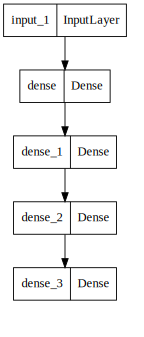

In [34]:
display(SVG(model_to_dot(ann, dpi=65).create(prog='dot', format='svg')))

### Treniranje mreže

In [35]:
ann.compile(loss='binary_crossentropy', 
            optimizer='adam', 
            metrics=['accuracy'])

In [36]:
history = ann.fit(X_train,
                  y_train,
                  epochs=50,
                  batch_size=128,
                  validation_data=(X_validation, y_validation))

Epoch 1/50
154/154 [==============================] - 87s 559ms/step - loss: 1.3362 - accuracy: 0.6736 - val_loss: 0.6885 - val_accuracy: 0.7052
Epoch 2/50
154/154 [==============================] - 17s 108ms/step - loss: 0.5283 - accuracy: 0.7900 - val_loss: 0.6059 - val_accuracy: 0.7438
Epoch 3/50
154/154 [==============================] - 16s 107ms/step - loss: 0.3496 - accuracy: 0.8594 - val_loss: 0.6758 - val_accuracy: 0.7395
Epoch 4/50
154/154 [==============================] - 17s 107ms/step - loss: 0.2370 - accuracy: 0.9101 - val_loss: 0.6974 - val_accuracy: 0.7359
Epoch 5/50
154/154 [==============================] - 16s 106ms/step - loss: 0.1954 - accuracy: 0.9289 - val_loss: 0.8453 - val_accuracy: 0.7350
Epoch 6/50
154/154 [==============================] - 16s 106ms/step - loss: 0.1831 - accuracy: 0.9360 - val_loss: 0.7685 - val_accuracy: 0.7363
Epoch 7/50
154/154 [==============================] - 16s 106ms/step - loss: 0.1450 - accuracy: 0.9487 - val_loss: 0.8338 - val_ac

### Ocena neuronske mreže

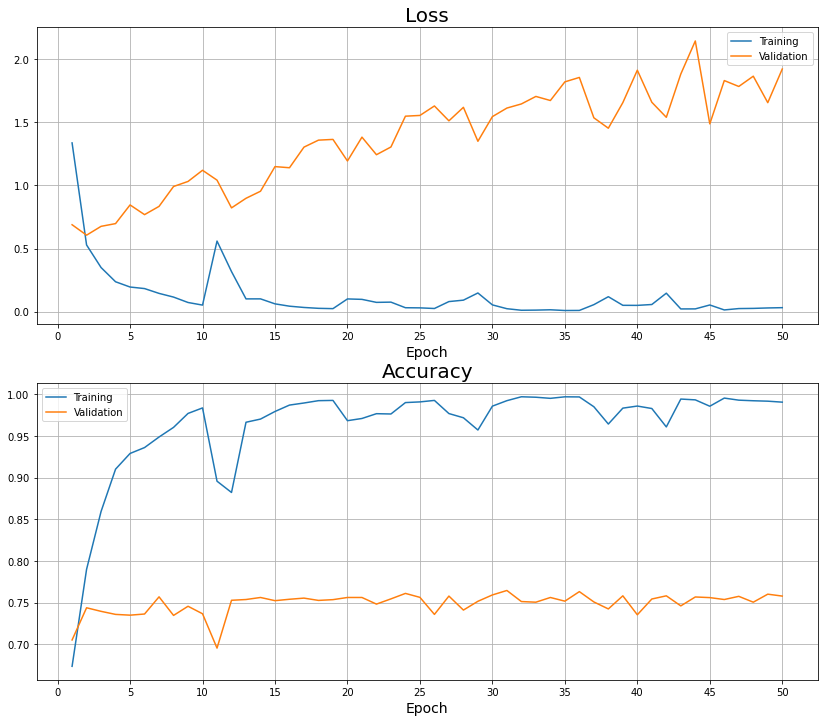

In [37]:
plt.figure(figsize=(14,12))

plt.subplot(2, 1, 1)

plt.plot(np.arange(1, 51), history.history['loss'], label='Training')
plt.plot(np.arange(1, 51), history.history['val_loss'], label='Validation')
plt.title('Loss', size=20)
plt.xlabel('Epoch', size=14)
plt.xticks(np.arange(0,51,5))
plt.grid()
plt.legend()


plt.subplot(2, 1, 2)

plt.plot(np.arange(1, 51), history.history['accuracy'], label='Training')
plt.plot(np.arange(1, 51), history.history['val_accuracy'], label='Validation')
plt.title('Accuracy', size=20)
plt.xlabel('Epoch', size=14)
plt.xticks(np.arange(0,51,5))
plt.grid()
plt.legend()

plt.savefig('assets/pictures/1.DM_1_ANN_Loss_Acc_first_try.jpg')

plt.show()

### Evaluacija

In [38]:
loss = ann.metrics_names[0]
acc = ann.metrics_names[1]

In [39]:
print('Evaluacija nad trening podacima:\n')

train_scores = ann.evaluate(X_train, y_train, batch_size=128)
print('{0}: {1}'.format(loss, train_scores[0]))
print('{0}: {1}'.format(acc, train_scores[1]))

Evaluacija nad trening podacima:

154/154 [==============================] - 6s 36ms/step - loss: 0.0118 - accuracy: 0.9956
loss: 0.011831493116915226
accuracy: 0.9956256151199341


In [40]:
print('Evaluacija nad test podacima:\n')

test_scores = ann.evaluate(X_test, y_test, batch_size=128)
print('Test skup {0}: {1}'.format(loss, test_scores[0]))
print('Test skup {0}: {1}'.format(acc, test_scores[1]))

Evaluacija nad test podacima:

52/52 [==============================] - 3s 39ms/step - loss: 1.8859 - accuracy: 0.7545
Test skup loss: 1.8859018087387085
Test skup accuracy: 0.7545010447502136


### Čuvanje modela neuronske mreže

In [41]:
with open('models/deep_models/DC_1_ANN_first_classifier.model.pickle', 'wb') as model_file:
    pickle.dump(ann, model_file)

INFO:tensorflow:Assets written to: ram://25912712-87ff-4a03-ad29-231ea1afcb12/assets


**Na osnovu grafika i rezultata može se primetiti da je model preprilagodjen. 
Naredni pokušaj je sa tehnikama regularizacije.**

# 1.2. Neuronska mreža sa regularizacijom

### Kreiranje mreže

In [42]:
ann2 = Sequential()

ann2.add(InputLayer(input_shape=(nx*ny*nrgb)))
ann2.add(Dense(units=int(nx*ny/(nrgb**3)), activation='relu', kernel_regularizer=l2(l=0.001)))
ann2.add(Dropout(rate=0.4))
ann2.add(Dense(units=128, activation='relu', kernel_regularizer=l2(l2=0.01)))
ann2.add(Dropout(rate=0.3))
ann2.add(Dense(units=64, activation='relu'))
ann2.add(Dropout(rate=0.2))
ann2.add(Dense(units=1, activation='sigmoid'))

### Opis mreže

In [43]:
ann2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 341)               9428309   
                                                                 
 dropout (Dropout)           (None, 341)               0         
                                                                 
 dense_5 (Dense)             (None, 128)               43776     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                

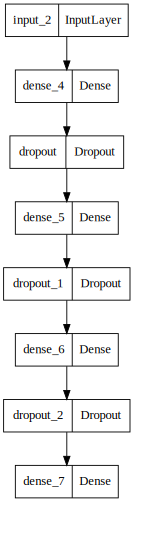

In [44]:
display(SVG(model_to_dot(ann2, dpi=65).create(prog='dot', format='svg')))

### Treniranje mreže

In [45]:
ann2.compile(loss='binary_crossentropy', 
             optimizer=Adam(learning_rate=0.001), 
             metrics=['accuracy'])

In [46]:
history2 = ann2.fit(X_train,
                    y_train,
                    epochs=50,
                    batch_size=128,
                    validation_data=(X_validation, y_validation))

Epoch 1/50
154/154 [==============================] - 134s 867ms/step - loss: 3.9816 - accuracy: 0.6086 - val_loss: 2.8283 - val_accuracy: 0.7203
Epoch 2/50
154/154 [==============================] - 24s 157ms/step - loss: 2.4972 - accuracy: 0.6628 - val_loss: 2.0819 - val_accuracy: 0.7142
Epoch 3/50
154/154 [==============================] - 24s 156ms/step - loss: 1.8082 - accuracy: 0.7081 - val_loss: 1.5432 - val_accuracy: 0.7244
Epoch 4/50
154/154 [==============================] - 24s 158ms/step - loss: 1.3792 - accuracy: 0.7199 - val_loss: 1.2199 - val_accuracy: 0.7218
Epoch 5/50
154/154 [==============================] - 24s 156ms/step - loss: 1.1105 - accuracy: 0.7308 - val_loss: 1.0092 - val_accuracy: 0.7424
Epoch 6/50
154/154 [==============================] - 24s 156ms/step - loss: 0.9422 - accuracy: 0.7390 - val_loss: 0.8944 - val_accuracy: 0.7353
Epoch 7/50
154/154 [==============================] - 24s 156ms/step - loss: 0.8375 - accuracy: 0.7453 - val_loss: 0.8094 - val_a

### Ocena neuronske mreže nakon regularizacije

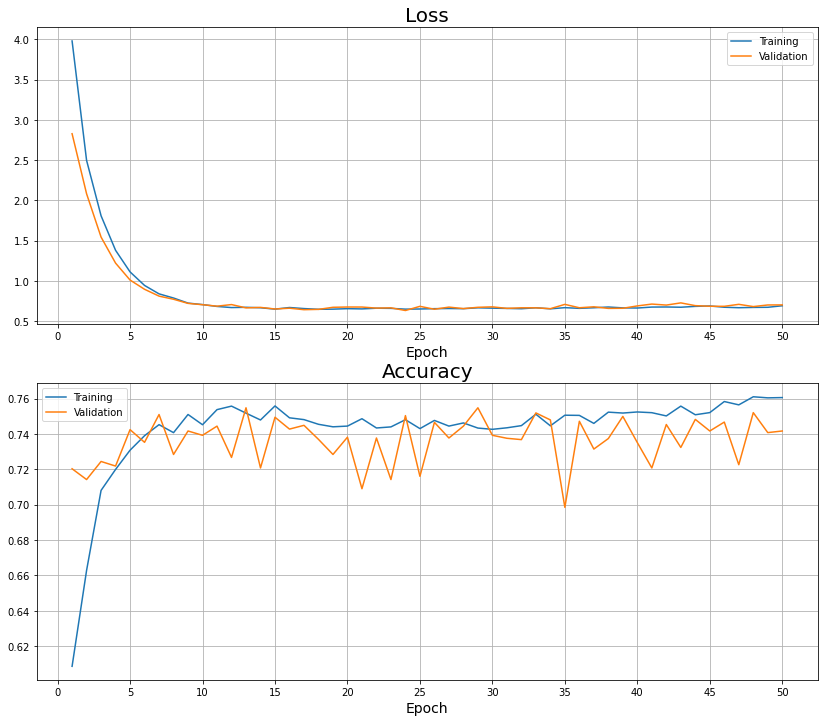

In [47]:
plt.figure(figsize=(14,12))

plt.subplot(2, 1, 1)

plt.plot(np.arange(1, 51), history2.history['loss'], label='Training')
plt.plot(np.arange(1, 51), history2.history['val_loss'], label='Validation')
plt.title('Loss', size=20)
plt.xlabel('Epoch', size=14)
plt.xticks(np.arange(0,51,5))
plt.grid()
plt.legend()


plt.subplot(2, 1, 2)

plt.plot(np.arange(1, 51), history2.history['accuracy'], label='Training')
plt.plot(np.arange(1, 51), history2.history['val_accuracy'], label='Validation')
plt.title('Accuracy', size=20)
plt.xlabel('Epoch', size=14)
plt.xticks(np.arange(0,51,5))
plt.grid()
plt.legend()

plt.savefig('assets/pictures/2.DM_1_ANN_Loss_Acc_second_try.jpg')

plt.show()

### Evaluacija nakon regularizacije

In [48]:
print('Evaluacija nad trening podacima:\n')

train_scores2 = ann2.evaluate(X_train, y_train, batch_size=128)
print('{0}: {1}'.format(loss, train_scores2[0]))
print('{0}: {1}'.format(acc, train_scores2[1]))

Evaluacija nad trening podacima:

154/154 [==============================] - 8s 53ms/step - loss: 0.6278 - accuracy: 0.7900
loss: 0.6277978420257568
accuracy: 0.7900305390357971


In [49]:
print('Evaluacija nad test podacima:\n')

test_scores2 = ann2.evaluate(X_test, y_test, batch_size=128)
print('Test skup {0}: {1}'.format(loss, test_scores2[0]))
print('Test skup {0}: {1}'.format(acc, test_scores2[1]))

Evaluacija nad test podacima:

52/52 [==============================] - 3s 50ms/step - loss: 0.6935 - accuracy: 0.7409
Test skup loss: 0.6935436129570007
Test skup accuracy: 0.7409215569496155


### Čuvanje modela neuronske mreže

In [50]:
with open('models/deep_models/DC_1_ANN_second_classifier.model.pickle', 'wb') as model_file:
    pickle.dump(ann2, model_file)

INFO:tensorflow:Assets written to: ram://f7e9ec2d-f4a1-4eb9-a89b-ba8395523a70/assets


# 2.1. Konvolutivna neuronska mreža

In [51]:
X_train = X_train_copy.reshape((X_train_copy.shape[0], nx, ny, nrgb))
X_validation = X_validation_copy.reshape((X_validation_copy.shape[0], nx, ny, nrgb))
X_test = X_test_copy.reshape((X_test_copy.shape[0], nx, ny, nrgb))

In [52]:
print("X_train shape = ",X_train.shape)
print("y_train shape = {} \n".format(y_train.shape))

print("X_validation shape = ",X_validation.shape)
print("y_validation shape = {} \n".format(y_validation.shape))

print("X_test shape = ",X_test.shape)
print("y_test shape = ",y_test.shape)

X_train shape =  (19660, 96, 96, 3)
y_train shape = (19660,) 

X_validation shape =  (6554, 96, 96, 3)
y_validation shape = (6554,) 

X_test shape =  (6554, 96, 96, 3)
y_test shape =  (6554,)


### Brisanje suvišnih podataka iz memorije 

In [53]:
del X_train_copy, X_validation_copy, X_test_copy

### Normalizacija

In [54]:
X_train = X_train / 255
X_validation = X_validation / 255
X_test = X_test / 255

In [55]:
print(X_train)

[[[[0.99607843 0.91372549 0.93333333]
   [0.96470588 0.90588235 0.91764706]
   [0.91372549 0.87058824 0.88627451]
   ...
   [0.21568627 0.0627451  0.23529412]
   [0.21176471 0.09019608 0.25098039]
   [0.20392157 0.10588235 0.25882353]]

  [[1.         0.91372549 0.94509804]
   [0.96862745 0.89411765 0.91764706]
   [1.         0.98039216 1.        ]
   ...
   [0.33333333 0.17254902 0.3372549 ]
   [0.25098039 0.1254902  0.27058824]
   [0.2        0.09803922 0.23529412]]

  [[0.74901961 0.64705882 0.69803922]
   [0.9254902  0.83137255 0.88235294]
   [0.91372549 0.83137255 0.86666667]
   ...
   [0.29803922 0.13333333 0.2745098 ]
   [0.23921569 0.10196078 0.22745098]
   [0.22745098 0.10980392 0.21960784]]

  ...

  [[0.81176471 0.63921569 0.72941176]
   [0.79215686 0.62745098 0.72156863]
   [0.89803922 0.76078431 0.85490196]
   ...
   [0.8        0.63921569 0.75686275]
   [0.40392157 0.23921569 0.38823529]
   [0.31372549 0.14509804 0.31372549]]

  [[0.96470588 0.80392157 0.86666667]
   [0.7

In [56]:
print(X_validation)

[[[[0.94509804 0.89803922 0.94509804]
   [0.89803922 0.86666667 0.90980392]
   [0.82352941 0.81176471 0.83921569]
   ...
   [1.         0.9254902  1.        ]
   [0.87843137 0.8745098  0.90588235]
   [0.85490196 0.93333333 0.92941176]]

  [[1.         0.91764706 1.        ]
   [0.9372549  0.85490196 0.92941176]
   [0.88235294 0.83529412 0.89019608]
   ...
   [1.         0.90196078 1.        ]
   [0.94901961 0.90196078 0.95686275]
   [0.89411765 0.9254902  0.9372549 ]]

  [[0.81960784 0.65882353 0.78431373]
   [0.96470588 0.82352941 0.93333333]
   [0.94901961 0.85098039 0.9372549 ]
   ...
   [0.58823529 0.39607843 0.52156863]
   [1.         0.95294118 1.        ]
   [0.8745098  0.85098039 0.89019608]]

  ...

  [[0.91372549 0.85882353 0.9254902 ]
   [0.89411765 0.84705882 0.90196078]
   [0.87843137 0.83529412 0.89019608]
   ...
   [0.89803922 0.87843137 0.90588235]
   [0.89803922 0.87843137 0.90588235]
   [0.89803922 0.87843137 0.90588235]]

  [[0.89803922 0.85098039 0.89803922]
   [0.8

In [57]:
print(X_test)

[[[[0.4745098  0.3372549  0.50196078]
   [0.63137255 0.49411765 0.65098039]
   [0.54901961 0.4        0.55294118]
   ...
   [0.70980392 0.54117647 0.64705882]
   [0.81960784 0.65098039 0.75686275]
   [0.74117647 0.58431373 0.69019608]]

  [[0.56862745 0.44313725 0.58823529]
   [0.61960784 0.48627451 0.62352941]
   [0.63137255 0.49411765 0.62352941]
   ...
   [0.96470588 0.76862745 0.88235294]
   [0.73333333 0.54117647 0.65882353]
   [0.77647059 0.58431373 0.70196078]]

  [[0.78823529 0.66666667 0.78823529]
   [0.68235294 0.55294118 0.6745098 ]
   [0.66666667 0.52941176 0.64705882]
   ...
   [0.84705882 0.61568627 0.74117647]
   [0.85098039 0.61568627 0.74901961]
   [0.94509804 0.70980392 0.84313725]]

  ...

  [[0.96470588 0.9372549  0.96470588]
   [0.98039216 0.95294118 0.98039216]
   [0.99607843 0.97647059 0.99215686]
   ...
   [0.98431373 0.97647059 0.98039216]
   [0.96078431 0.95686275 0.94901961]
   [0.99215686 0.97647059 0.97254902]]

  [[0.83137255 0.76470588 0.80392157]
   [0.9

### Kreiranje konvolutivne mreže

In [58]:
cnn = Sequential()

In [59]:
cnn.add(Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[96, 96, 3]))
cnn.add(MaxPool2D(pool_size=2, strides=2))
cnn.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(MaxPool2D(pool_size=2, strides=2))
cnn.add(Flatten())
cnn.add(Dense(units=128, activation='relu'))
cnn.add(Dense(units=64, activation='relu'))
cnn.add(Dense(units=1, activation='sigmoid'))

### Sumacija postavke konvolutivne mreže

In [60]:
cnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 47, 47, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 45, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 22, 22, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 15488)             0         
                                                                 
 dense_8 (Dense)             (None, 128)              

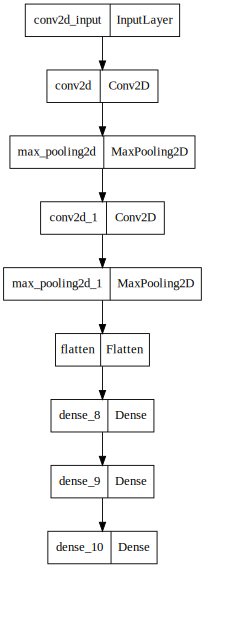

In [61]:
display(SVG(model_to_dot(cnn, dpi=65).create(prog='dot', format='svg')))

### Treniranje konvolutivne mreže

In [62]:
cnn.compile(optimizer = 'adam', 
            loss = 'binary_crossentropy', 
            metrics = ['accuracy'])

In [63]:
history_cnn = cnn.fit(x = X_train, 
                      y = y_train, 
                      validation_data = (X_validation, y_validation), 
                      epochs = 50)

Epoch 1/50
615/615 [==============================] - 121s 194ms/step - loss: 0.5158 - accuracy: 0.7514 - val_loss: 0.4971 - val_accuracy: 0.7794
Epoch 2/50
615/615 [==============================] - 112s 182ms/step - loss: 0.4573 - accuracy: 0.7923 - val_loss: 0.4286 - val_accuracy: 0.8105
Epoch 3/50
615/615 [==============================] - 112s 182ms/step - loss: 0.3990 - accuracy: 0.8270 - val_loss: 0.4108 - val_accuracy: 0.8178
Epoch 4/50
615/615 [==============================] - 111s 180ms/step - loss: 0.3420 - accuracy: 0.8548 - val_loss: 0.4422 - val_accuracy: 0.8076
Epoch 5/50
615/615 [==============================] - 111s 180ms/step - loss: 0.2702 - accuracy: 0.8885 - val_loss: 0.5031 - val_accuracy: 0.7910
Epoch 6/50
615/615 [==============================] - 111s 180ms/step - loss: 0.1860 - accuracy: 0.9253 - val_loss: 0.5228 - val_accuracy: 0.8145
Epoch 7/50
615/615 [==============================] - 111s 180ms/step - loss: 0.1039 - accuracy: 0.9614 - val_loss: 0.8432 -

### Evaluacija konvolutivne mreže

In [64]:
print('Evaluacija nad trening podacima:\n')

train_scores_cnn = cnn.evaluate(X_train, y_train, batch_size=128)
print('{0}: {1}'.format(loss, train_scores_cnn[0]))
print('{0}: {1}'.format(acc, train_scores_cnn[1]))

Evaluacija nad trening podacima:

154/154 [==============================] - 30s 181ms/step - loss: 5.6632e-07 - accuracy: 1.0000
loss: 5.66315975447651e-07
accuracy: 1.0


In [65]:
print('Evaluacija nad test podacima:\n')

test_scores_cnn = cnn.evaluate(X_test, y_test, batch_size=128)
print('{0}: {1}'.format(loss, test_scores_cnn[0]))
print('{0}: {1}'.format(acc, test_scores_cnn[1]))

Evaluacija nad test podacima:

52/52 [==============================] - 9s 171ms/step - loss: 2.1632 - accuracy: 0.8230
loss: 2.1632003784179688
accuracy: 0.8230088353157043


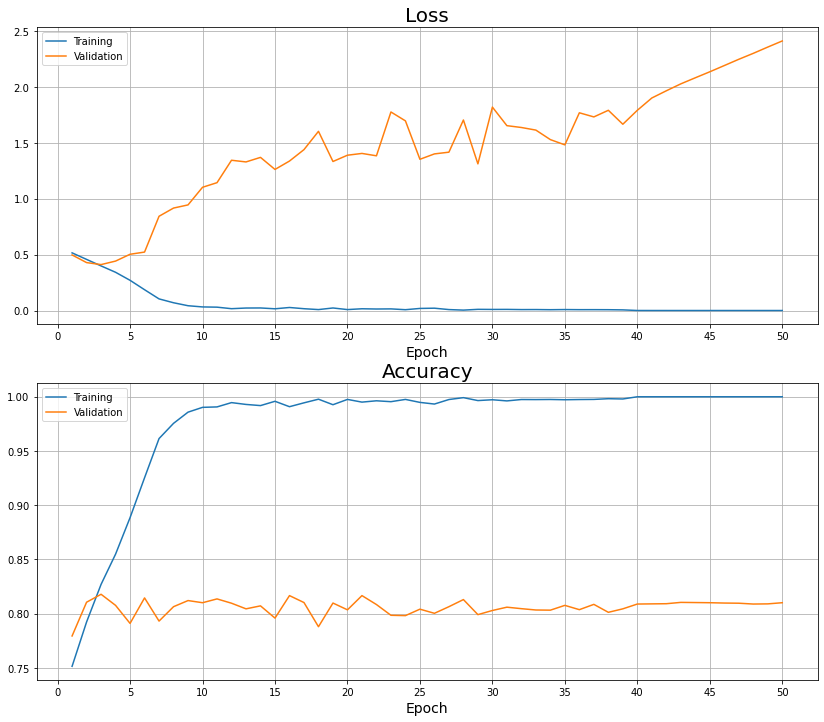

In [66]:
plt.figure(figsize=(14,12))

plt.subplot(2, 1, 1)

plt.plot(np.arange(1, 51), history_cnn.history['loss'], label='Training')
plt.plot(np.arange(1, 51), history_cnn.history['val_loss'], label='Validation')
plt.title('Loss', size=20)
plt.xlabel('Epoch', size=14)
plt.xticks(np.arange(0,51,5))
plt.grid()
plt.legend()


plt.subplot(2, 1, 2)

plt.plot(np.arange(1, 51), history_cnn.history['accuracy'], label='Training')
plt.plot(np.arange(1, 51), history_cnn.history['val_accuracy'], label='Validation')
plt.title('Accuracy', size=20)
plt.xlabel('Epoch', size=14)
plt.xticks(np.arange(0,51,5))
plt.grid()
plt.legend()

plt.savefig('assets/pictures/3.DM_2_CNN_Loss_Acc_first_try.jpg')

plt.show()

### Čuvanje modela konvolutivne neuronske mreže

In [67]:
with open('models/deep_models/DC_2_CNN_first_classifier.model.pickle', 'wb') as model_file:
    pickle.dump(cnn, model_file)

INFO:tensorflow:Assets written to: ram://5a1a997e-231e-499b-93a7-5cf3ae234ca5/assets


INFO:tensorflow:Assets written to: ram://5a1a997e-231e-499b-93a7-5cf3ae234ca5/assets


# 2.2 Konvolutivna mreža drugi pristup

### Kreiranje mreže

In [82]:
cnn2 = Sequential([Input(shape=[96,96,3]),
                   Conv2D(filters=32, kernel_size=3, activation='relu'),
                   MaxPool2D(pool_size=2, strides=2),
                   Conv2D(filters=32, kernel_size=3, activation='relu'),
                   MaxPool2D(pool_size=2, strides=2),
                   Dropout(0.4),
                   Flatten(),
                   Dense(128, activation='relu', kernel_regularizer=l2(l2=0.01)),
                   Dropout(0.3),
                   Dense(64, activation='relu', kernel_regularizer=l2(l2=0.01)),
                   Dropout(0.2),
                   Dense(1, activation='sigmoid')])

### Opis mreže

In [83]:
cnn2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 47, 47, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 45, 45, 32)        9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 22, 22, 32)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 22, 22, 32)        0         
                                                                 
 flatten_2 (Flatten)         (None, 15488)            

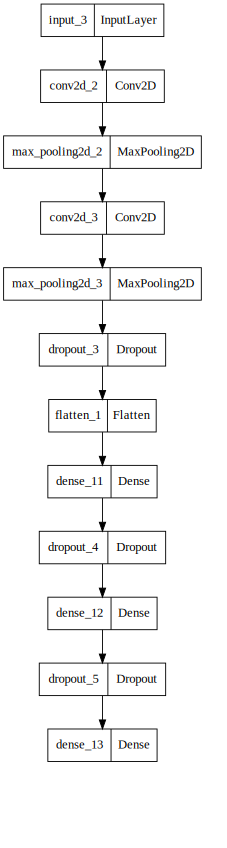

In [70]:
display(SVG(model_to_dot(cnn2, dpi=65).create(prog='dot', format='svg')))

### Treniranje mreže

In [84]:
cnn2.compile(loss='binary_crossentropy', 
             optimizer=Adam(learning_rate=0.001), 
             metrics=['accuracy'])

In [85]:
history_cnn2 = cnn2.fit(X_train,
                        y_train,
                        validation_data= (X_validation, y_validation),
                        batch_size=128,
                        epochs=50)

Epoch 1/50
154/154 [==============================] - 207s 1s/step - loss: 1.2003 - accuracy: 0.6940 - val_loss: 0.6506 - val_accuracy: 0.7693
Epoch 2/50
154/154 [==============================] - 107s 697ms/step - loss: 0.5917 - accuracy: 0.7766 - val_loss: 0.5373 - val_accuracy: 0.7922
Epoch 3/50
154/154 [==============================] - 107s 698ms/step - loss: 0.5372 - accuracy: 0.7811 - val_loss: 0.5086 - val_accuracy: 0.7867
Epoch 4/50
154/154 [==============================] - 107s 693ms/step - loss: 0.5150 - accuracy: 0.7909 - val_loss: 0.5145 - val_accuracy: 0.7868
Epoch 5/50
154/154 [==============================] - 108s 702ms/step - loss: 0.5113 - accuracy: 0.7888 - val_loss: 0.4948 - val_accuracy: 0.7952
Epoch 6/50
154/154 [==============================] - 107s 695ms/step - loss: 0.5070 - accuracy: 0.7889 - val_loss: 0.4886 - val_accuracy: 0.8039
Epoch 7/50
154/154 [==============================] - 108s 702ms/step - loss: 0.4963 - accuracy: 0.7954 - val_loss: 0.4960 - va

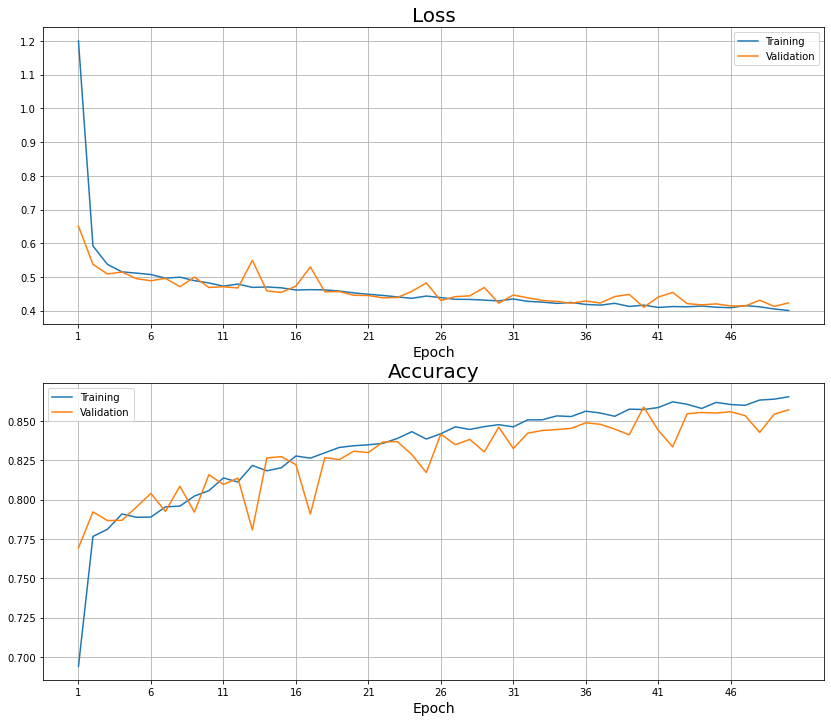

In [86]:
plt.figure(figsize=(14,12))

plt.subplot(2, 1, 1)

plt.plot(np.arange(1, 51), history_cnn2.history['loss'], label='Training')
plt.plot(np.arange(1, 51), history_cnn2.history['val_loss'], label='Validation')
plt.title('Loss', size=20)
plt.xlabel('Epoch', size=14)
plt.xticks(np.arange(1, 51, 5))
plt.grid()
plt.legend()


plt.subplot(2, 1, 2)

plt.plot(np.arange(1, 51), history_cnn2.history['accuracy'], label='Training')
plt.plot(np.arange(1, 51), history_cnn2.history['val_accuracy'], label='Validation')
plt.title('Accuracy', size=20)
plt.xlabel('Epoch', size=14)
plt.xticks(np.arange(1, 51, 5))
plt.grid()
plt.legend()

plt.savefig('assets/pictures/4.DM_2_CNN_Loss_Acc_second_try.jpg')

plt.show()

### Evaluacija 

In [87]:
train_scores_cnn2 = cnn2.evaluate(X_train, y_train, batch_size=128)
print('Training skup {0}: {1:.2f}%'.format(cnn2.metrics_names[1], train_scores_cnn2[1]))
print('Training skup {0}: {1}'.format(cnn2.metrics_names[0], train_scores_cnn2[0]))

154/154 [==============================] - 26s 171ms/step - loss: 0.3728 - accuracy: 0.8790
Training skup accuracy: 0.88%
Training skup loss: 0.37284761667251587


In [88]:
test_scores_cnn2 = cnn2.evaluate(X_test, y_test, batch_size=128)
print('Test skup {0}: {1:.2f}%'.format(cnn2.metrics_names[1], test_scores_cnn2[1]))
print('Test skup {0}: {1}'.format(cnn2.metrics_names[0], test_scores_cnn2[0]))

52/52 [==============================] - 11s 210ms/step - loss: 0.3920 - accuracy: 0.8688
Test skup accuracy: 0.87%
Test skup loss: 0.3920220136642456


### Čuvanje modela konvolutivne neuronske mreže

In [89]:
with open('models/deep_models/DC_2_CNN_second_classifier.model.pickle', 'wb') as model_file:
    pickle.dump(cnn2, model_file)

INFO:tensorflow:Assets written to: ram://a8513605-92fb-44a7-b219-e177866b57ea/assets


INFO:tensorflow:Assets written to: ram://a8513605-92fb-44a7-b219-e177866b57ea/assets


# 3. Uporedjivanje Train vs. Validation podataka neuronske i konvolutivne mreže
Samo popravljene verzije neuronske i konvolutivne mreže posmatramo ovde

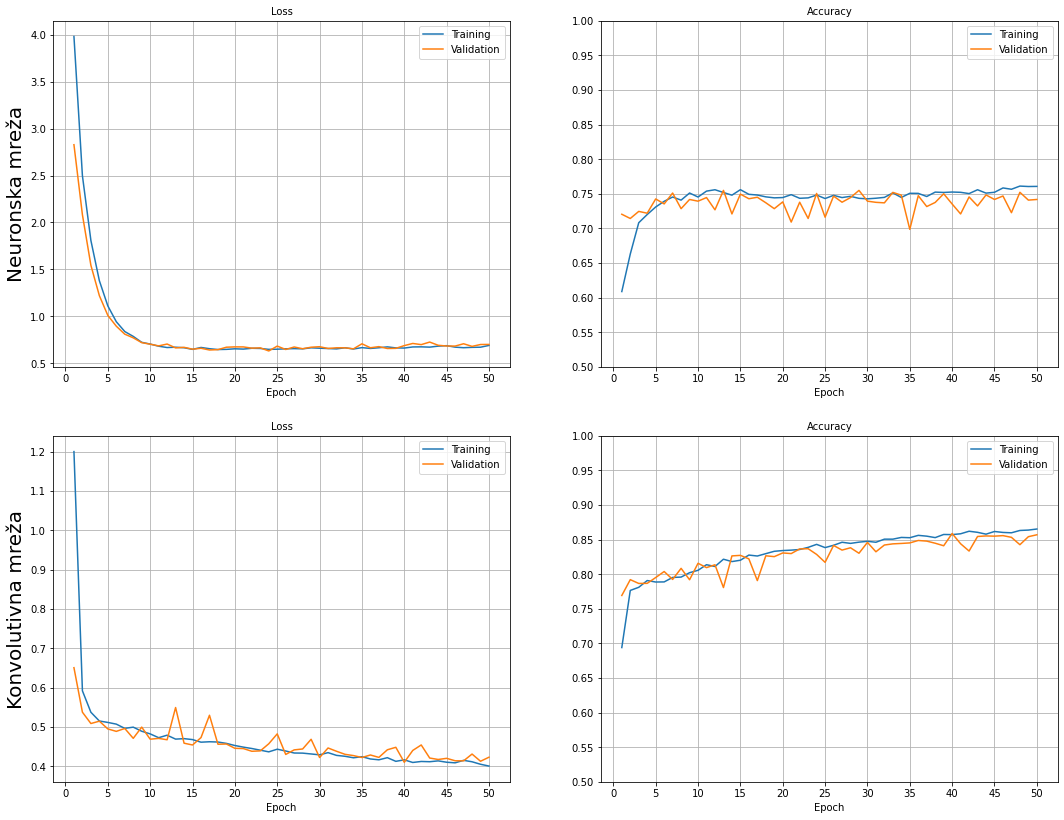

In [90]:
plt.figure(figsize=(18,14))

plt.subplot(2, 2, 1)

plt.title('Train vs. Validation - Neuronska i Konvolutivna mreža', size=20)
plt.ylabel('Neuronska mreža', size=20)

plt.plot(np.arange(1, 51), history2.history['loss'], label='Training')
plt.plot(np.arange(1, 51), history2.history['val_loss'], label='Validation')
plt.title('Loss', size=10)
plt.xlabel('Epoch', size=10)
plt.xticks(np.arange(0,51,5))
plt.grid()
plt.legend()


plt.subplot(2, 2, 2)

plt.plot(np.arange(1, 51), history2.history['accuracy'], label='Training')
plt.plot(np.arange(1, 51), history2.history['val_accuracy'], label='Validation')
plt.title('Accuracy', size=10)
plt.xlabel('Epoch', size=10)
plt.xticks(np.arange(0,51,5))
plt.yticks(np.linspace(0.5,1,11))
plt.grid()
plt.legend()


plt.subplot(2, 2, 3)
plt.ylabel('Konvolutivna mreža', size=20)

plt.plot(np.arange(1, 51), history_cnn2.history['loss'], label='Training')
plt.plot(np.arange(1, 51), history_cnn2.history['val_loss'], label='Validation')
plt.title('Loss', size=10)
plt.xlabel('Epoch', size=10)
plt.xticks(np.arange(0,51,5))
plt.grid()
plt.legend()


plt.subplot(2, 2, 4)

plt.plot(np.arange(1, 51), history_cnn2.history['accuracy'], label='Training')
plt.plot(np.arange(1, 51), history_cnn2.history['val_accuracy'], label='Validation')
plt.title('Accuracy', size=10)
plt.xlabel('Epoch', size=10)
plt.xticks(np.arange(0,51,5))
plt.yticks(np.linspace(0.5,1,11))
plt.grid()
plt.legend()

plt.savefig('assets/pictures/5.DM_Conclusion_ANN_vs_CNN.jpg')


plt.show()

### Uvećavanje slika i postavljanje na iste podeoke zbog preciznijeg uporedjivanja
Rezultati prvih nekoliko epoha će biti isečeni jer će se loss posmatrati na podeoku [0.4, 1], a accuracy na podeoku [0.6, 0.9] zbog preciznijeg uvida u odnos oba poboljšana modela. 

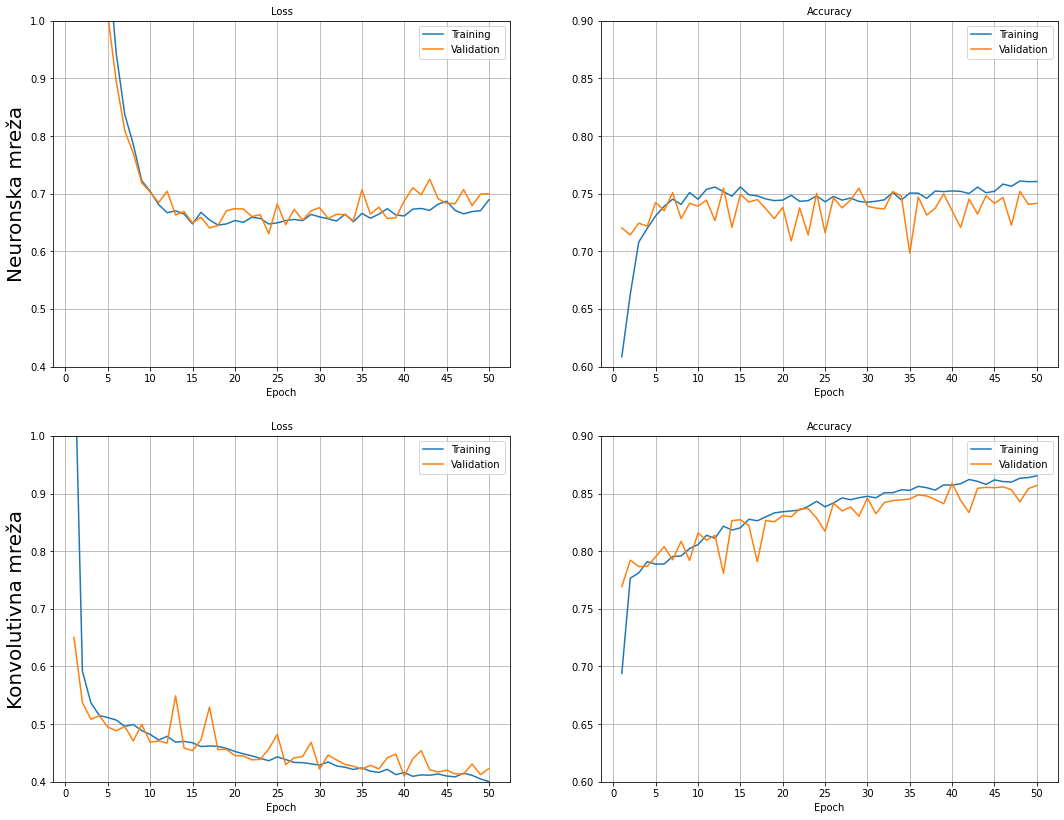

In [91]:
plt.figure(figsize=(18,14))

plt.subplot(2, 2, 1)

plt.title('Train vs. Validation - Neuronska i Konvolutivna mreža', size=20)
plt.ylabel('Neuronska mreža', size=20)

plt.plot(np.arange(1, 51), history2.history['loss'], label='Training')
plt.plot(np.arange(1, 51), history2.history['val_loss'], label='Validation')
plt.title('Loss', size=10)
plt.xlabel('Epoch', size=10)
plt.ylim(0.4,1)
plt.xticks(np.arange(0,51,5))
plt.grid()
plt.legend()


plt.subplot(2, 2, 2)

plt.plot(np.arange(1, 51), history2.history['accuracy'], label='Training')
plt.plot(np.arange(1, 51), history2.history['val_accuracy'], label='Validation')
plt.title('Accuracy', size=10)
plt.xlabel('Epoch', size=10)
plt.ylim(0.6,0.9)
plt.xticks(np.arange(0,51,5))
plt.grid()
plt.legend()


plt.subplot(2, 2, 3)
plt.ylabel('Konvolutivna mreža', size=20)

plt.plot(np.arange(1, 51), history_cnn2.history['loss'], label='Training')
plt.plot(np.arange(1, 51), history_cnn2.history['val_loss'], label='Validation')
plt.title('Loss', size=10)
plt.xlabel('Epoch', size=10)
plt.ylim(0.4,1)
plt.xticks(np.arange(0,51,5))
plt.grid()
plt.legend()


plt.subplot(2, 2, 4)

plt.plot(np.arange(1, 51), history_cnn2.history['accuracy'], label='Training')
plt.plot(np.arange(1, 51), history_cnn2.history['val_accuracy'], label='Validation')
plt.title('Accuracy', size=10)
plt.xlabel('Epoch', size=10)
plt.ylim(0.6,0.9)
plt.xticks(np.arange(0,51,5))
plt.grid()
plt.legend()

plt.savefig('assets/pictures/6.DM_Conclusion_ANN_vs_CNN_zoomed.jpg')


plt.show()

Kovolutivna mreža se ispostavila kao najbolji model za predikciju slika. 
Iz ovog grafika se vidi da bi potencijalno rezultat mogao biti bolji ako bi mreža duže bila trenirana, tako da je broj epoha dupliran u narednom delu koda.

# Uporedjivanje rezultata evaluacije nad test podacima
Pogledaćemo nad sva 4 trenirana modela (dva preprilagodjena i dva popravljena) kako su se kretali rezultati loss i accuracy nad test podacima.

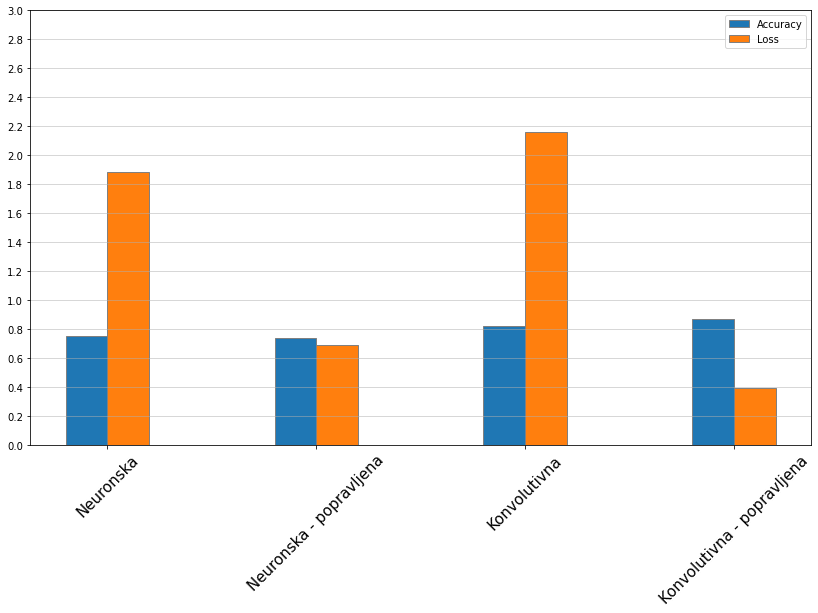

In [92]:
labels = ["Neuronska", "Neuronska - popravljena", "Konvolutivna", "Konvolutivna - popravljena"]
losses = [test_scores[0], test_scores2[0],test_scores_cnn[0], test_scores_cnn2[0]]
accs = [test_scores[1], test_scores2[1],test_scores_cnn[1], test_scores_cnn2[1]]
val_labels = ['Accuracy', 'Loss']
vals = [accs, losses]

x_axis = np.arange(len(labels))
move = [-1/2, 1/2]
width = 0.2
upper_y_lim = int(max(max(losses), max(accs))) + 1

plt.figure(figsize = (14,8))
for i in range(len(move)):
    plt.bar(x_axis + width*move[i], vals[i], width, edgecolor='gray')

plt.xticks(x_axis, labels, rotation = 45, size = 15)
plt.yticks(np.linspace(0, upper_y_lim, 16))

plt.legend(val_labels)
plt.grid(axis = 'y', linewidth = 0.5)

plt.savefig('assets/pictures/7.DM_eval_comparisson_ANN_CNN_all_models.jpg')

plt.show()

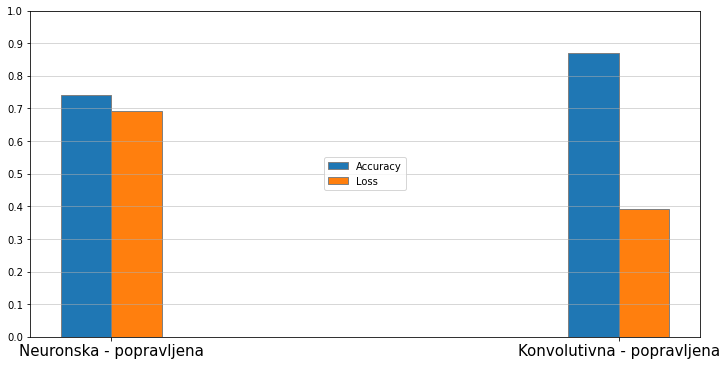

In [106]:
test_scores2
test_scores_cnn2

labels = ["Neuronska - popravljena", "Konvolutivna - popravljena"]
losses = [test_scores2[0], test_scores_cnn2[0]]
accs = [test_scores2[1], test_scores_cnn2[1]]
val_labels = ['Accuracy', 'Loss']
vals = [accs, losses]

x_axis = np.arange(len(labels))
move = [-1/2, 1/2]
width = 0.1
upper_y_lim = int(max(max(losses), max(accs))) + 1

plt.figure(figsize = (12,6))
for i in range(len(move)):
    plt.bar(x_axis + width*move[i], vals[i], width, edgecolor='gray')

plt.xticks(x_axis, labels, size = 15)
plt.yticks(np.linspace(0, upper_y_lim,(upper_y_lim+1)*5+1))

plt.legend(val_labels, loc='center')
plt.grid(axis = 'y', linewidth = 0.5)

plt.savefig('assets/pictures/8.DM_eval_comparisson_ANN_CNN_fox_fixed_models.jpg')

plt.show()

# 4. Popravljena Konvolutivna mreža - trening na 100 epoha
Iz prethodnog se videlo da bi možda uz više epoha popravljena konvolutivna mreža mogla da da bolje rezultate, pa sa 50 epoha podižemo trening mreže na 100 epoha.

In [94]:
history_cnn3 = cnn2.fit(X_train,
                        y_train,
                        validation_data= (X_validation, y_validation),
                        batch_size=128,
                        epochs=100)

Epoch 1/100
154/154 [==============================] - 158s 1s/step - loss: 0.4049 - accuracy: 0.8651 - val_loss: 0.4116 - val_accuracy: 0.8575
Epoch 2/100
154/154 [==============================] - 109s 706ms/step - loss: 0.3985 - accuracy: 0.8681 - val_loss: 0.4069 - val_accuracy: 0.8573
Epoch 3/100
154/154 [==============================] - 107s 698ms/step - loss: 0.3997 - accuracy: 0.8677 - val_loss: 0.4464 - val_accuracy: 0.8464
Epoch 4/100
154/154 [==============================] - 111s 722ms/step - loss: 0.4046 - accuracy: 0.8684 - val_loss: 0.4083 - val_accuracy: 0.8581
Epoch 5/100
154/154 [==============================] - 109s 711ms/step - loss: 0.3956 - accuracy: 0.8680 - val_loss: 0.4059 - val_accuracy: 0.8598
Epoch 6/100
154/154 [==============================] - 110s 713ms/step - loss: 0.4007 - accuracy: 0.8664 - val_loss: 0.4199 - val_accuracy: 0.8578
Epoch 7/100
154/154 [==============================] - 109s 711ms/step - loss: 0.4008 - accuracy: 0.8696 - val_loss: 0.41

154/154 [==============================] - 110s 711ms/step - loss: 0.3761 - accuracy: 0.8906 - val_loss: 0.4082 - val_accuracy: 0.8732
Epoch 57/100
154/154 [==============================] - 109s 710ms/step - loss: 0.3819 - accuracy: 0.8883 - val_loss: 0.4147 - val_accuracy: 0.8720
Epoch 58/100
154/154 [==============================] - 110s 712ms/step - loss: 0.3780 - accuracy: 0.8876 - val_loss: 0.4023 - val_accuracy: 0.8769
Epoch 59/100
154/154 [==============================] - 110s 713ms/step - loss: 0.3747 - accuracy: 0.8909 - val_loss: 0.4199 - val_accuracy: 0.8723
Epoch 60/100
154/154 [==============================] - 109s 709ms/step - loss: 0.3768 - accuracy: 0.8893 - val_loss: 0.4088 - val_accuracy: 0.8756
Epoch 61/100
154/154 [==============================] - 109s 710ms/step - loss: 0.3715 - accuracy: 0.8924 - val_loss: 0.4053 - val_accuracy: 0.8782
Epoch 62/100
154/154 [==============================] - 109s 709ms/step - loss: 0.3761 - accuracy: 0.8935 - val_loss: 0.4048 

### Finalna evaluacija konvolutivne mreže

In [99]:
print('Evaluacija nad trening podacima:\n')

train_scores_cnn_f = cnn2.evaluate(X_train, y_train, batch_size=128)
print('{0}: {1}'.format(loss, train_scores_cnn_f[0]))
print('{0}: {1}'.format(acc, train_scores_cnn_f[1]))

poboljšanje = (train_scores_cnn_f[1]*100)/train_scores_cnn2[1] - 100

print('Poboljšanje tacnosti: {:.2f}%'.format(poboljšanje))

Evaluacija nad trening podacima:

154/154 [==============================] - 29s 186ms/step - loss: 0.3104 - accuracy: 0.9276
loss: 0.3104158639907837
accuracy: 0.9275686740875244
Poboljšanje tacnosti: 5.53%


In [98]:
print('Evaluacija nad test podacima:\n')

test_scores_cnn_f = cnn2.evaluate(X_test, y_test, batch_size=128)
print('Test skup {0}: {1}'.format(loss, test_scores_cnn_f[0]))
print('Test skup {0}: {1}'.format(acc, test_scores_cnn_f[1]))

poboljšanje = (test_scores_cnn_f[1]*100)/test_scores_cnn2[1] - 100

print('Poboljšanje tacnosti: {:.2f}%'.format(poboljšanje))

Evaluacija nad test podacima:

52/52 [==============================] - 11s 207ms/step - loss: 0.3871 - accuracy: 0.8933
Test skup loss: 0.3870885372161865
Test skup accuracy: 0.8933475613594055
Poboljšanje tacnosti: 2.83%


### Poboljšanje nakon dupliranja epoha

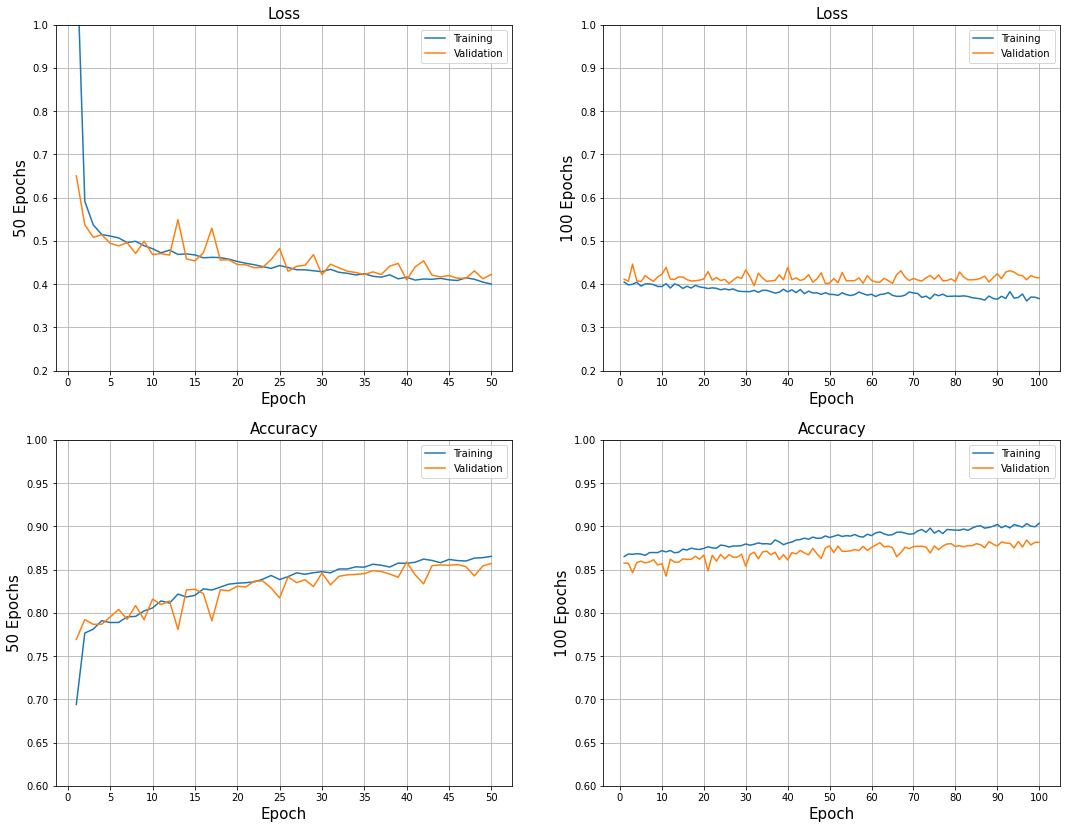

In [105]:
plt.figure(figsize=(18,14))

plt.subplot(2, 2, 1)

plt.plot(np.arange(1, 51), history_cnn2.history['loss'], label='Training')
plt.plot(np.arange(1, 51), history_cnn2.history['val_loss'], label='Validation')
plt.title('Loss', size=15)
plt.xlabel('Epoch', size=15)
plt.ylabel('50 Epochs', size=15)
plt.ylim(0.2,1)
plt.xticks(np.arange(0,51,5))
plt.grid()
plt.legend()


plt.subplot(2, 2, 2)

plt.plot(np.arange(1, 101), history_cnn3.history['loss'], label='Training')
plt.plot(np.arange(1, 101), history_cnn3.history['val_loss'], label='Validation')
plt.title('Loss', size=15)
plt.xlabel('Epoch', size=15)
plt.ylabel('100 Epochs', size=15)
plt.ylim(0.2,1)
plt.xticks(np.arange(0,101,10))
plt.grid()
plt.legend()



plt.subplot(2, 2, 3)

plt.plot(np.arange(1, 51), history_cnn2.history['accuracy'], label='Training')
plt.plot(np.arange(1, 51), history_cnn2.history['val_accuracy'], label='Validation')
plt.title('Accuracy', size=15)
plt.xlabel('Epoch', size=15)
plt.ylabel('50 Epochs', size=15)
plt.ylim(0.6,1)
plt.xticks(np.arange(0,51,5))
plt.grid()
plt.legend()

plt.subplot(2, 2, 4)

plt.plot(np.arange(1, 101), history_cnn3.history['accuracy'], label='Training')
plt.plot(np.arange(1, 101), history_cnn3.history['val_accuracy'], label='Validation')
plt.title('Accuracy', size=15)
plt.xlabel('Epoch', size=15)
plt.ylabel('100 Epochs', size=15)
plt.ylim(0.6,1)
plt.xticks(np.arange(0,101,10))
plt.grid()
plt.legend()

plt.savefig('assets/pictures/9.DM_final_CNN_comparisson_100_vs_50_epochs_zoomed.jpg')


plt.show()

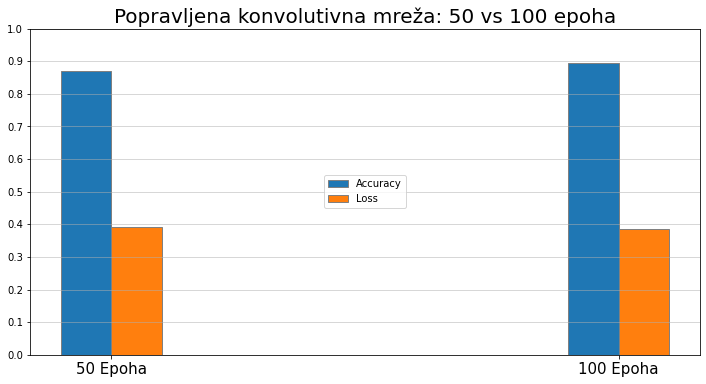

In [103]:
labels = ["50 Epoha", "100 Epoha"]
losses = [test_scores_cnn2[0], test_scores_cnn_f[0]]
accs = [test_scores_cnn2[1], test_scores_cnn_f[1]]
val_labels = ['Accuracy', 'Loss']
vals = [accs, losses]

x_axis = np.arange(len(labels))
move = [-1/2, 1/2]
width = 0.1
upper_y_lim = int(max(max(losses), max(accs))) + 1

plt.figure(figsize = (12,6))
plt.title("Popravljena konvolutivna mreža: 50 vs 100 epoha", size = 20)
for i in range(len(move)):
    plt.bar(x_axis + width*move[i], vals[i], width, edgecolor='gray')

plt.xticks(x_axis, labels, size = 15)
plt.yticks(np.linspace(0, upper_y_lim,(upper_y_lim+1)*5+1))

plt.legend(val_labels, loc='center')
plt.grid(axis = 'y', linewidth = 0.5)

plt.savefig('assets/pictures/10.DM_final_CNN_eval_comparisson_100_vs_50_epochs.jpg')

plt.show()

# Zaključak
Najbolji model koji je dobijen iz svih dosadašnjih klasifikacija je Konvolutivna neuronska mreža. U ovom slučaju, najbolji rezultat, dobijen nakon regularizacije i 100 epoha treniranja, je **89.33%** preciznosti predvidjanja slika limfnih čvorova.